# Práctica 2

### Notebook de Feature Engineering

### Parte 1 - Modelo exponencial de covid-19 usando el dataset mostrado en clase

In [1]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib as mp
from matplotlib import pyplot as plt
#from sklearn.linear_model import LinearRegression
import tensorflow as tf
import datetime, os
##from datetime import timedelta

In [2]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Carga y depuración de los Datos

In [3]:
link = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
covidgbl_df = pd.read_csv(link)

In [4]:
covidgbl_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21,6/8/21,6/9/21,6/10/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,72977,74026,75119,76628,77963,79224,80841,82326,84050,85892
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,132337,132351,132360,132372,132374,132379,132384,132397,132415,132426
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,129218,129640,129976,130361,130681,130958,131283,131647,132034,132355
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,13729,13744,13752,13758,13758,13758,13777,13781,13791,13805
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,34752,34960,35140,35307,35594,35772,35854,36004,36115,36325


### Elimina columnas que no utilizables

In [5]:
covidgbl_df = covidgbl_df.drop(['Lat','Long'], axis = 1)

## Filtra solo el país Guatemala

In [6]:
# Filtra Guatemala
covidgt = covidgbl_df[covidgbl_df['Country/Region'] == 'Guatemala']

In [7]:
covidgt

,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21,6/8/21,6/9/21,6/10/21
138,NaN,Guatemala,0,0,0,0,0,0,0,0,...,255833,257167,258633,259954,261392,261958,262255,263836,265662,267447


### Cambio del formato ancho a un formato largo del dataframe

In [8]:
covidgt = covidgt.melt(id_vars=['Country/Region','Province/State'])
covidgt.head(20)

,Country/Region,Province/State,variable,value
0,Guatemala,NaN,1/22/20,0
1,Guatemala,NaN,1/23/20,0
2,Guatemala,NaN,1/24/20,0
3,Guatemala,NaN,1/25/20,0
4,Guatemala,NaN,1/26/20,0
5,Guatemala,NaN,1/27/20,0
6,Guatemala,NaN,1/28/20,0
7,Guatemala,NaN,1/29/20,0
8,Guatemala,NaN,1/30/20,0
9,Guatemala,NaN,1/31/20,0


### Renombra nombres de columnas

In [42]:
covidgt.rename(columns = {'variable':'Date', 'value':'Confirmed'}, inplace = True)
covidgt.head(20)

,Country/Region,Province/State,Date,Confirmed,numDias,ln(confirmed)
52,Guatemala,NaN,2020-03-14,1,1,0.000000
53,Guatemala,NaN,2020-03-15,1,2,0.000000
54,Guatemala,NaN,2020-03-16,2,3,0.693147
55,Guatemala,NaN,2020-03-17,6,4,1.791759
56,Guatemala,NaN,2020-03-18,6,5,1.791759
57,Guatemala,NaN,2020-03-19,9,6,2.197225
58,Guatemala,NaN,2020-03-20,12,7,2.484907
59,Guatemala,NaN,2020-03-21,17,8,2.833213
60,Guatemala,NaN,2020-03-22,19,9,2.944439
61,Guatemala,NaN,2020-03-23,20,10,2.995732


### Prepara dataframe para el análisis y entrenamiento
#### (1) El valor de columna Date se convierte a formato de fecha
#### (2) Filtra solo los casos confirmados
#### (3) Convierte la fecha a un entero "número de día", para encontrar el día Cero como inicio del primer contagio registrado en Guatemala

In [43]:
# (1)
covidgt["Date"] = pd.to_datetime(covidgt["Date"],infer_datetime_format = True)

# (2)
covidgt = covidgt[covidgt['Confirmed']>0]

# (3)
lenDate = len(covidgt["Date"])
covidgt["numDias"] = np.linspace(start= 1, stop = lenDate, num = lenDate, dtype = int)

### Gráficas del dataframe preparado

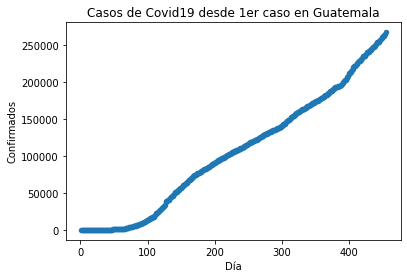

In [11]:
covidgt.plot.scatter(x = "numDias",y="Confirmed")
plt.title('Casos de Covid19 desde 1er caso en Guatemala')
plt.xlabel("Día")
plt.ylabel('Confirmados')
plt.show()

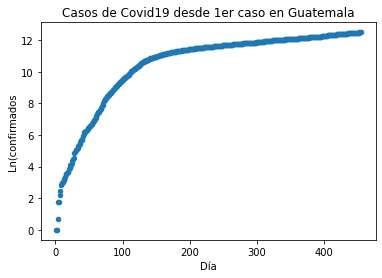

In [12]:
covidgt["ln(confirmed)"] = np.log(covidgt["Confirmed"])
covidgt.plot.scatter(x = "numDias",y="ln(confirmed)")
plt.title('Casos de Covid19 desde 1er caso en Guatemala')
plt.xlabel("Día")
plt.ylabel('Ln(confirmados')
plt.show()

In [13]:
covidgt.head(20)

,Country/Region,Province/State,Date,Confirmed,numDias,ln(confirmed)
52,Guatemala,NaN,2020-03-14,1,1,0.000000
53,Guatemala,NaN,2020-03-15,1,2,0.000000
54,Guatemala,NaN,2020-03-16,2,3,0.693147
55,Guatemala,NaN,2020-03-17,6,4,1.791759
56,Guatemala,NaN,2020-03-18,6,5,1.791759
57,Guatemala,NaN,2020-03-19,9,6,2.197225
58,Guatemala,NaN,2020-03-20,12,7,2.484907
59,Guatemala,NaN,2020-03-21,17,8,2.833213
60,Guatemala,NaN,2020-03-22,19,9,2.944439
61,Guatemala,NaN,2020-03-23,20,10,2.995732


### Inconsistencias
#### Por posible inconsistencia en los datos (datos no registrados) de la 1er semana (14/03/2020 al 20/03/2020), no se toman en cuenta

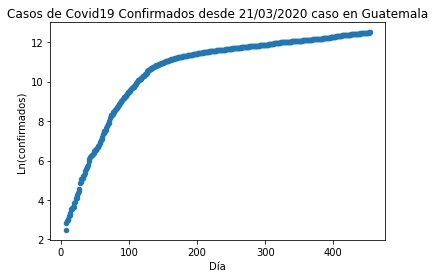

In [14]:
#
covidgt_lineal = covidgt[(covidgt['numDias'] > 6)]

covidgt_lineal.plot.scatter(x = 'numDias', y = 'ln(confirmed)')

plt.title('Casos de Covid19 Confirmados desde 21/03/2020 caso en Guatemala')
plt.xlabel("Día")
plt.ylabel('Ln(confirmados)')


plt.show()

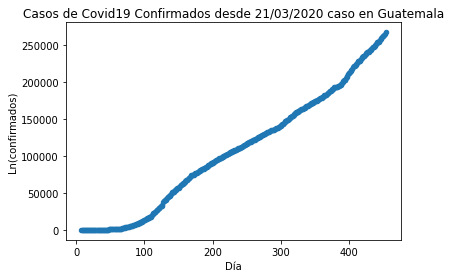

In [15]:
covidgt_lineal.plot.scatter(x = 'numDias', y = 'Confirmed')

plt.title('Casos de Covid19 Confirmados desde 21/03/2020 caso en Guatemala')
plt.xlabel("Día")
plt.ylabel('Ln(confirmados)')


plt.show()

## Definición de la clase para el Modelo aplicando TensorFlow

In [16]:
class modeloLineal:
    def __init__(self):
        # Inicializa el vector de weights
        self.w = tf.get_variable("weights", dtype = tf.float32, shape = [1,2], initializer = tf.zeros_initializer())
        
    # Funcion para generar prediccion de modelo
    def __call__(self, x):
        with tf.name_scope("modelo"):
            # Mutiplica la matriz de entramiento con el vector de los pesos (weights)
            return tf.matmul(self.w,x)
        
    # Actualiza parámetros usando gradient descent
    def actualiza(self, x, y, lg):
        with tf.name_scope("error"):
            error = self.error(x,y)
            # Escribe al grafo el MSE
            error_r = tf.summary.scalar("ErrorR", error)
            
        gradient = tf.gradients(error, [self.w])
        # Actualiza parámetros
        upd_w = tf.assign(self.w, self.w - lg * gradient[0])
        return upd_w, error, error_r
    
    # Calcula MSE
    def error(self, x, y):
        error = 1/2 * tf.reduce_mean(tf.math.square(y - self(x)))
        return error

### Función de entrenamiento con tensorFlow con método Mini Batch

In [17]:
# Entrenamiento
def f_entrena(lr, epochs, visual, bs):
    # Path y nombre archivos para verlo con Tensorboard
    archivo = './covidgr/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr="+str(lr)+ "_ep="+str(epochs) + "_bS="+str(bs)
    
    totite = int(len(covidgt_lineal["ln(confirmed)"])/bs)
    
    print(len(covidgt_lineal["ln(confirmed)"]), totite)
      
    tf.reset_default_graph()
    gr = tf.Graph()
    with gr.as_default(): #objeto para el contenido del grafo
        
        # Placeholders para el grafo
        t_x = tf.placeholder(tf.float32, [2,None], "t_x")
        t_y = tf.placeholder(tf.float32, [None], "t_y")
        
        # Inicialización de objeto de clase
        modelo = modeloLineal()

        # Utilizacion de método update para hacer el entrenamiento
        parametros = modelo.actualiza(t_x, t_y, lr)
        
        # Crea archivo
        writer = tf.summary.FileWriter(archivo, gr)
        
        # Inicializa variables
        with tf.train.MonitoredSession() as session:
            for epoch in range(epochs): #5 epochs
                 
                for i in range(totite):
                    muestra_inicio = i*bs
                    muestra_fin = muestra_inicio + bs
                    
                    x_mb =  np.array(x[muestra_inicio:muestra_fin]).reshape([-1,1])
                    y_mb = np.array(y[muestra_inicio:muestra_fin]).reshape([-1,1])

                    # Diccionario de modelo resultante
                    d_param = {t_x:x, t_y:y}

                    # Entrenamiento
                    training = session.run(parametros, feed_dict = d_param)

                    # # evalúa si imprime o no la iteración, el peso y valor del costo del entrenamiento
                    if (i)%visual == 0:
                        # actualiza las predicciones del modelo
                        weights = session.run(modelo.w, feed_dict = d_param)
                        # Escribe en archivo el entrenamiento
                        writer.add_summary(training[2], i)
                        print("Conteo epoch: ", epoch, "Iteracion: ",i, "Weights: ", weights, "Costo: ", training[1])
            return weights, training[1]
            writer.close()

## Aplicar regresión lineal sobre la variable "Confirmed" transformada. ln(confirmed)

In [19]:
x = covidgt_lineal["numDias"]
x = np.array([x, np.ones_like(x)], dtype = "float64")
y = covidgt_lineal["ln(confirmed)"]

## Entrenamientos
#### Parámetros de la función f_entrena(lr, epochs, visual, batch_size)

### Entrenamiento 1

In [20]:
w,e = f_entrena(0.0000001, 20,5,8)

448 56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Conteo epoch:  0 Iteracion:  0 Weights:  [[2.6867914e-04 1.0573419e-06]] Costo:  58.647346
Conteo epoch:  0 Iteracion:  5 Weights:  [[1.5841821e-03 6.2520139e-06]] Costo:  55.14925
Conteo epoch:  0 Iteracion:  10 Weights:  [[2.8543747e-03 1.1297176e-05]] Costo:  51.887974
Conteo epoch:  0 Iteracion:  15 Weights:  [[4.0808171e-03 1.6197977e-05]] Costo:  48.84748
Conteo epoch:  0 Iteracion:  20 Weights:  [[5.2650161e-03 2.0959389e-05]] Costo:  46.012836
Conteo epoch:  0 Iteracion:  25 Weights:  [[6.4084274e-03 2.5586212e-05]] Costo:  43.3701
Conteo epoch:  0 Iteracion:  30 Weights:  [[7.5124558e-03 3.0083085e-05]] Costo:  40.90628
Conteo epoch:  0 Iteracion:  35 Weights:  [[8.5784579e-03 3.4454482e-05]] Costo:  38.609253
Conteo epoch:  0 Iteracion:  40 Weights:  [[9.6077416e-03 3.8704722e-05]] Costo:  36.467747
Conteo epoch:  0 Iteracion:  45 Weights:  [[1.060157

Conteo epoch:  8 Iteracion:  30 Weights:  [[0.03712267 0.0002043 ]] Costo:  7.040635
Conteo epoch:  8 Iteracion:  35 Weights:  [[0.03716878 0.00020531]] Costo:  7.0363355
Conteo epoch:  8 Iteracion:  40 Weights:  [[0.0372133  0.00020631]] Costo:  7.0323267
Conteo epoch:  8 Iteracion:  45 Weights:  [[0.03725629 0.0002073 ]] Costo:  7.0285883
Conteo epoch:  8 Iteracion:  50 Weights:  [[0.0372978  0.00020829]] Costo:  7.025104
Conteo epoch:  8 Iteracion:  55 Weights:  [[0.03733788 0.00020928]] Costo:  7.021855
Conteo epoch:  9 Iteracion:  0 Weights:  [[0.03734573 0.00020948]] Costo:  7.0212317
Conteo epoch:  9 Iteracion:  5 Weights:  [[0.03738416 0.00021046]] Costo:  7.0182443
Conteo epoch:  9 Iteracion:  10 Weights:  [[0.03742127 0.00021143]] Costo:  7.01546
Conteo epoch:  9 Iteracion:  15 Weights:  [[0.03745709 0.0002124 ]] Costo:  7.012863
Conteo epoch:  9 Iteracion:  20 Weights:  [[0.03749168 0.00021337]] Costo:  7.010443
Conteo epoch:  9 Iteracion:  25 Weights:  [[0.03752508 0.000214

Conteo epoch:  16 Iteracion:  45 Weights:  [[0.03840914 0.00028762]] Costo:  6.977102
Conteo epoch:  16 Iteracion:  50 Weights:  [[0.03841094 0.00028848]] Costo:  6.9770937
Conteo epoch:  16 Iteracion:  55 Weights:  [[0.03841267 0.00028934]] Costo:  6.9770865
Conteo epoch:  17 Iteracion:  0 Weights:  [[0.03841301 0.00028951]] Costo:  6.9770856
Conteo epoch:  17 Iteracion:  5 Weights:  [[0.03841466 0.00029037]] Costo:  6.9770775
Conteo epoch:  17 Iteracion:  10 Weights:  [[0.03841627 0.00029123]] Costo:  6.9770713
Conteo epoch:  17 Iteracion:  15 Weights:  [[0.03841781 0.00029209]] Costo:  6.977065
Conteo epoch:  17 Iteracion:  20 Weights:  [[0.03841931 0.00029294]] Costo:  6.9770584
Conteo epoch:  17 Iteracion:  25 Weights:  [[0.03842074 0.0002938 ]] Costo:  6.9770536
Conteo epoch:  17 Iteracion:  30 Weights:  [[0.03842214 0.00029466]] Costo:  6.9770474
Conteo epoch:  17 Iteracion:  35 Weights:  [[0.03842348 0.00029552]] Costo:  6.977043
Conteo epoch:  17 Iteracion:  40 Weights:  [[0.0

### Entrenamiento 2

In [21]:
w,e = f_entrena(0.000001, 20,5,8)

448 56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Conteo epoch:  0 Iteracion:  0 Weights:  [[2.6867914e-03 1.0573420e-05]] Costo:  58.647346
Conteo epoch:  0 Iteracion:  5 Weights:  [[1.3554269e-02 5.4971955e-05]] Costo:  32.023346
Conteo epoch:  0 Iteracion:  10 Weights:  [[2.1120485e-02 8.8477362e-05]] Costo:  19.117859
Conteo epoch:  0 Iteracion:  15 Weights:  [[0.02638827 0.0001144 ]] Costo:  12.862163
Conteo epoch:  0 Iteracion:  20 Weights:  [[0.03005584 0.00013504]] Costo:  9.829827
Conteo epoch:  0 Iteracion:  25 Weights:  [[0.03260928 0.000152  ]] Costo:  8.359954
Conteo epoch:  0 Iteracion:  30 Weights:  [[0.03438704 0.00016641]] Costo:  7.6474533
Conteo epoch:  0 Iteracion:  35 Weights:  [[0.03562476 0.00017903]] Costo:  7.3020754
Conteo epoch:  0 Iteracion:  40 Weights:  [[0.03648648 0.00019042]] Costo:  7.1346517
Conteo epoch:  0 Iteracion:  45 Weights:  [[0.03708643 0.00020093]] Costo:  7.0534887

Conteo epoch:  8 Iteracion:  10 Weights:  [[0.0384592  0.00091077]] Costo:  6.9759445
Conteo epoch:  8 Iteracion:  15 Weights:  [[0.03845917 0.00091931]] Costo:  6.9759293
Conteo epoch:  8 Iteracion:  20 Weights:  [[0.03845915 0.00092785]] Costo:  6.975915
Conteo epoch:  8 Iteracion:  25 Weights:  [[0.03845912 0.00093639]] Costo:  6.9759
Conteo epoch:  8 Iteracion:  30 Weights:  [[0.03845909 0.00094492]] Costo:  6.975887
Conteo epoch:  8 Iteracion:  35 Weights:  [[0.03845906 0.00095346]] Costo:  6.9758716
Conteo epoch:  8 Iteracion:  40 Weights:  [[0.03845904 0.000962  ]] Costo:  6.9758563
Conteo epoch:  8 Iteracion:  45 Weights:  [[0.03845901 0.00097054]] Costo:  6.975842
Conteo epoch:  8 Iteracion:  50 Weights:  [[0.03845898 0.00097908]] Costo:  6.9758277
Conteo epoch:  8 Iteracion:  55 Weights:  [[0.03845895 0.00098762]] Costo:  6.9758124
Conteo epoch:  9 Iteracion:  0 Weights:  [[0.03845894 0.00098932]] Costo:  6.97581
Conteo epoch:  9 Iteracion:  5 Weights:  [[0.03845891 0.0009978

Conteo epoch:  18 Iteracion:  10 Weights:  [[0.03845605 0.00186699]] Costo:  6.974312
Conteo epoch:  18 Iteracion:  15 Weights:  [[0.03845602 0.00187553]] Costo:  6.974297
Conteo epoch:  18 Iteracion:  20 Weights:  [[0.03845599 0.00188407]] Costo:  6.9742823
Conteo epoch:  18 Iteracion:  25 Weights:  [[0.03845596 0.00189261]] Costo:  6.9742675
Conteo epoch:  18 Iteracion:  30 Weights:  [[0.03845593 0.00190114]] Costo:  6.974253
Conteo epoch:  18 Iteracion:  35 Weights:  [[0.03845591 0.00190968]] Costo:  6.974239
Conteo epoch:  18 Iteracion:  40 Weights:  [[0.03845588 0.00191822]] Costo:  6.974224
Conteo epoch:  18 Iteracion:  45 Weights:  [[0.03845585 0.00192676]] Costo:  6.9742093
Conteo epoch:  18 Iteracion:  50 Weights:  [[0.03845582 0.00193529]] Costo:  6.9741945
Conteo epoch:  18 Iteracion:  55 Weights:  [[0.0384558  0.00194383]] Costo:  6.9741807
Conteo epoch:  19 Iteracion:  0 Weights:  [[0.03845579 0.00194554]] Costo:  6.974178
Conteo epoch:  19 Iteracion:  5 Weights:  [[0.0384

### Entrenamiento 3

In [22]:
w,e = f_entrena(0.00001, 20,5,8)

448 56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Conteo epoch:  0 Iteracion:  0 Weights:  [[0.02686791 0.00010573]] Costo:  58.647346
Conteo epoch:  0 Iteracion:  5 Weights:  [[0.0384326  0.00022929]] Costo:  6.9774547
Conteo epoch:  0 Iteracion:  10 Weights:  [[0.0384611  0.00031477]] Costo:  6.976989
Conteo epoch:  0 Iteracion:  15 Weights:  [[0.03846089 0.00040016]] Costo:  6.976844
Conteo epoch:  0 Iteracion:  20 Weights:  [[0.03846061 0.00048555]] Costo:  6.9766974
Conteo epoch:  0 Iteracion:  25 Weights:  [[0.03846033 0.00057094]] Costo:  6.9765515
Conteo epoch:  0 Iteracion:  30 Weights:  [[0.03846005 0.00065633]] Costo:  6.976405
Conteo epoch:  0 Iteracion:  35 Weights:  [[0.03845976 0.00074171]] Costo:  6.9762597
Conteo epoch:  0 Iteracion:  40 Weights:  [[0.03845948 0.0008271 ]] Costo:  6.9761133
Conteo epoch:  0 Iteracion:  45 Weights:  [[0.0384592  0.00091248]] Costo:  6.975967
Conteo epoch:  0 It

Conteo epoch:  9 Iteracion:  25 Weights:  [[0.03843194 0.00917278]] Costo:  6.9618692
Conteo epoch:  9 Iteracion:  30 Weights:  [[0.03843166 0.00925806]] Costo:  6.9617243
Conteo epoch:  9 Iteracion:  35 Weights:  [[0.03843138 0.00934334]] Costo:  6.961579
Conteo epoch:  9 Iteracion:  40 Weights:  [[0.0384311  0.00942862]] Costo:  6.9614334
Conteo epoch:  9 Iteracion:  45 Weights:  [[0.03843082 0.00951391]] Costo:  6.9612885
Conteo epoch:  9 Iteracion:  50 Weights:  [[0.03843053 0.00959919]] Costo:  6.9611435
Conteo epoch:  9 Iteracion:  55 Weights:  [[0.03843025 0.00968446]] Costo:  6.960998
Conteo epoch:  10 Iteracion:  0 Weights:  [[0.0384302  0.00970152]] Costo:  6.9609685
Conteo epoch:  10 Iteracion:  5 Weights:  [[0.03842992 0.0097868 ]] Costo:  6.960823
Conteo epoch:  10 Iteracion:  10 Weights:  [[0.03842964 0.00987207]] Costo:  6.960678
Conteo epoch:  10 Iteracion:  15 Weights:  [[0.03842935 0.00995735]] Costo:  6.960532
Conteo epoch:  10 Iteracion:  20 Weights:  [[0.03842907 0

Conteo epoch:  19 Iteracion:  25 Weights:  [[0.03840045 0.01871821]] Costo:  6.9455996
Conteo epoch:  19 Iteracion:  30 Weights:  [[0.03840017 0.01880338]] Costo:  6.9454536
Conteo epoch:  19 Iteracion:  35 Weights:  [[0.03839988 0.01888855]] Costo:  6.945309
Conteo epoch:  19 Iteracion:  40 Weights:  [[0.0383996  0.01897372]] Costo:  6.945164
Conteo epoch:  19 Iteracion:  45 Weights:  [[0.03839932 0.01905889]] Costo:  6.945019
Conteo epoch:  19 Iteracion:  50 Weights:  [[0.03839904 0.01914406]] Costo:  6.9448733
Conteo epoch:  19 Iteracion:  55 Weights:  [[0.03839876 0.01922922]] Costo:  6.9447284


### Entrenamiento 4

In [23]:
w,e = f_entrena(0.0001, 20,5,8)

448 56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Conteo epoch:  0 Iteracion:  0 Weights:  [[0.2686791  0.00105734]] Costo:  58.647346
Conteo epoch:  0 Iteracion:  5 Weights:  [[-1768.7954       -5.8354344]] Costo:  3050247400.0
Conteo epoch:  0 Iteracion:  10 Weights:  [[13590488.       44844.258]] Costo:  1.8006568e+17
Conteo epoch:  0 Iteracion:  15 Weights:  [[-1.04419844e+11 -3.44552064e+08]] Costo:  1.0629846e+25
Conteo epoch:  0 Iteracion:  20 Weights:  [[8.022894e+14 2.647298e+12]] Costo:  6.2751316e+32
Conteo epoch:  0 Iteracion:  25 Weights:  [[-6.1642327e+18 -2.0339992e+16]] Costo:  inf
Conteo epoch:  0 Iteracion:  30 Weights:  [[4.7361664e+22 1.5627832e+20]] Costo:  inf
Conteo epoch:  0 Iteracion:  35 Weights:  [[-3.638941e+26 -1.200734e+24]] Costo:  inf
Conteo epoch:  0 Iteracion:  40 Weights:  [[2.7959081e+30 9.2256016e+27]] Costo:  inf
Conteo epoch:  0 Iteracion:  45 Weights:  [[-2.148181e+34 -7

Conteo epoch:  11 Iteracion:  25 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  11 Iteracion:  30 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  11 Iteracion:  35 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  11 Iteracion:  40 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  11 Iteracion:  45 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  11 Iteracion:  50 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  11 Iteracion:  55 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  12 Iteracion:  0 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  12 Iteracion:  5 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  12 Iteracion:  10 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  12 Iteracion:  15 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  12 Iteracion:  20 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  12 Iteracion:  25 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  12 Iteracion:  30 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  12 Iteracion:  35 Weights:  [[nan nan]] Costo:  n

### Entrenamiento 5

In [24]:
w,e = f_entrena(0.0001, 20,5,12)

448 37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Conteo epoch:  0 Iteracion:  0 Weights:  [[0.2686791  0.00105734]] Costo:  58.647346
Conteo epoch:  0 Iteracion:  5 Weights:  [[-1768.7954       -5.8354344]] Costo:  3050247400.0
Conteo epoch:  0 Iteracion:  10 Weights:  [[13590488.       44844.258]] Costo:  1.8006568e+17
Conteo epoch:  0 Iteracion:  15 Weights:  [[-1.04419844e+11 -3.44552064e+08]] Costo:  1.0629846e+25
Conteo epoch:  0 Iteracion:  20 Weights:  [[8.022894e+14 2.647298e+12]] Costo:  6.2751316e+32
Conteo epoch:  0 Iteracion:  25 Weights:  [[-6.1642327e+18 -2.0339992e+16]] Costo:  inf
Conteo epoch:  0 Iteracion:  30 Weights:  [[4.7361664e+22 1.5627832e+20]] Costo:  inf
Conteo epoch:  0 Iteracion:  35 Weights:  [[-3.638941e+26 -1.200734e+24]] Costo:  inf
Conteo epoch:  1 Iteracion:  0 Weights:  [[-1.3037495e+28 -4.3019569e+25]] Costo:  inf
Conteo epoch:  1 Iteracion:  5 Weights:  [[1.0017101e+32 3.

Conteo epoch:  15 Iteracion:  20 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  15 Iteracion:  25 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  15 Iteracion:  30 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  15 Iteracion:  35 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  16 Iteracion:  0 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  16 Iteracion:  5 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  16 Iteracion:  10 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  16 Iteracion:  15 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  16 Iteracion:  20 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  16 Iteracion:  25 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  16 Iteracion:  30 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  16 Iteracion:  35 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  17 Iteracion:  0 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  17 Iteracion:  5 Weights:  [[nan nan]] Costo:  nan
Conteo epoch:  17 Iteracion:  10 Weights:  [[nan nan]] Costo:  nan

### Entrenamiento 6

In [25]:
w,e = f_entrena(0.0001, 5,5,12)

448 37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Conteo epoch:  0 Iteracion:  0 Weights:  [[0.2686791  0.00105734]] Costo:  58.647346
Conteo epoch:  0 Iteracion:  5 Weights:  [[-1768.7954       -5.8354344]] Costo:  3050247400.0
Conteo epoch:  0 Iteracion:  10 Weights:  [[13590488.       44844.258]] Costo:  1.8006568e+17
Conteo epoch:  0 Iteracion:  15 Weights:  [[-1.04419844e+11 -3.44552064e+08]] Costo:  1.0629846e+25
Conteo epoch:  0 Iteracion:  20 Weights:  [[8.022894e+14 2.647298e+12]] Costo:  6.2751316e+32
Conteo epoch:  0 Iteracion:  25 Weights:  [[-6.1642327e+18 -2.0339992e+16]] Costo:  inf
Conteo epoch:  0 Iteracion:  30 Weights:  [[4.7361664e+22 1.5627832e+20]] Costo:  inf
Conteo epoch:  0 Iteracion:  35 Weights:  [[-3.638941e+26 -1.200734e+24]] Costo:  inf
Conteo epoch:  1 Iteracion:  0 Weights:  [[-1.3037495e+28 -4.3019569e+25]] Costo:  inf
Conteo epoch:  1 Iteracion:  5 Weights:  [[1.0017101e+32 3.

### Entrenamiento 7

In [26]:
w,e = f_entrena(0.0001, 5,5,6)

448 74
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Conteo epoch:  0 Iteracion:  0 Weights:  [[0.2686791  0.00105734]] Costo:  58.647346
Conteo epoch:  0 Iteracion:  5 Weights:  [[-1768.7954       -5.8354344]] Costo:  3050247400.0
Conteo epoch:  0 Iteracion:  10 Weights:  [[13590488.       44844.258]] Costo:  1.8006568e+17
Conteo epoch:  0 Iteracion:  15 Weights:  [[-1.04419844e+11 -3.44552064e+08]] Costo:  1.0629846e+25
Conteo epoch:  0 Iteracion:  20 Weights:  [[8.022894e+14 2.647298e+12]] Costo:  6.2751316e+32
Conteo epoch:  0 Iteracion:  25 Weights:  [[-6.1642327e+18 -2.0339992e+16]] Costo:  inf
Conteo epoch:  0 Iteracion:  30 Weights:  [[4.7361664e+22 1.5627832e+20]] Costo:  inf
Conteo epoch:  0 Iteracion:  35 Weights:  [[-3.638941e+26 -1.200734e+24]] Costo:  inf
Conteo epoch:  0 Iteracion:  40 Weights:  [[2.7959081e+30 9.2256016e+27]] Costo:  inf
Conteo epoch:  0 Iteracion:  45 Weights:  [[-2.148181e+34 -7

### Entrenamiento 8

In [28]:
w,e = f_entrena(0.00001, 1000,200,2)

448 224
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Conteo epoch:  0 Iteracion:  0 Weights:  [[0.02686791 0.00010573]] Costo:  58.647346
Conteo epoch:  0 Iteracion:  200 Weights:  [[0.03845046 0.00355886]] Costo:  6.97145
Conteo epoch:  1 Iteracion:  0 Weights:  [[0.03844911 0.00396854]] Costo:  6.9707503
Conteo epoch:  1 Iteracion:  200 Weights:  [[0.03843785 0.00738158]] Costo:  6.9649243
Conteo epoch:  2 Iteracion:  0 Weights:  [[0.0384365  0.00779104]] Costo:  6.964227
Conteo epoch:  2 Iteracion:  200 Weights:  [[0.03842524 0.01120225]] Costo:  6.958409
Conteo epoch:  3 Iteracion:  0 Weights:  [[0.0384239  0.01161149]] Costo:  6.957711
Conteo epoch:  3 Iteracion:  200 Weights:  [[0.03841265 0.01502087]] Costo:  6.9518995
Conteo epoch:  4 Iteracion:  0 Weights:  [[0.03841129 0.01542989]] Costo:  6.9512024
Conteo epoch:  4 Iteracion:  200 Weights:  [[0.03840005 0.01883745]] Costo:  6.945396
Conteo epoch:  5 I

Conteo epoch:  48 Iteracion:  200 Weights:  [[0.03785257 0.18475682]] Costo:  6.6660657
Conteo epoch:  49 Iteracion:  0 Weights:  [[0.03785125 0.18515593]] Costo:  6.665401
Conteo epoch:  49 Iteracion:  200 Weights:  [[0.03784028 0.18848187]] Costo:  6.6598706
Conteo epoch:  50 Iteracion:  0 Weights:  [[0.03783896 0.18888098]] Costo:  6.659206
Conteo epoch:  50 Iteracion:  200 Weights:  [[0.03782799 0.19220556]] Costo:  6.65368
Conteo epoch:  51 Iteracion:  0 Weights:  [[0.03782668 0.19260432]] Costo:  6.6530166
Conteo epoch:  51 Iteracion:  200 Weights:  [[0.03781571 0.19592728]] Costo:  6.6474967
Conteo epoch:  52 Iteracion:  0 Weights:  [[0.0378144  0.19632603]] Costo:  6.6468344
Conteo epoch:  52 Iteracion:  200 Weights:  [[0.03780344 0.19964653]] Costo:  6.6413207
Conteo epoch:  53 Iteracion:  0 Weights:  [[0.03780213 0.20004493]] Costo:  6.640659
Conteo epoch:  53 Iteracion:  200 Weights:  [[0.03779117 0.2033647 ]] Costo:  6.6351495
Conteo epoch:  54 Iteracion:  0 Weights:  [[0.0

Conteo epoch:  97 Iteracion:  200 Weights:  [[0.03725789 0.3649802 ]] Costo:  6.3701215
Conteo epoch:  98 Iteracion:  0 Weights:  [[0.03725661 0.3653693 ]] Costo:  6.3694906
Conteo epoch:  98 Iteracion:  200 Weights:  [[0.03724591 0.3686108 ]] Costo:  6.3642397
Conteo epoch:  99 Iteracion:  0 Weights:  [[0.03724463 0.36899918]] Costo:  6.3636103
Conteo epoch:  99 Iteracion:  200 Weights:  [[0.03723395 0.37223572]] Costo:  6.3583703
Conteo epoch:  100 Iteracion:  0 Weights:  [[0.03723267 0.3726241 ]] Costo:  6.3577423
Conteo epoch:  100 Iteracion:  200 Weights:  [[0.03722199 0.37586063]] Costo:  6.352504
Conteo epoch:  101 Iteracion:  0 Weights:  [[0.03722071 0.37624902]] Costo:  6.3518753
Conteo epoch:  101 Iteracion:  200 Weights:  [[0.03721003 0.37948555]] Costo:  6.346641
Conteo epoch:  102 Iteracion:  0 Weights:  [[0.03720875 0.37987393]] Costo:  6.3460135
Conteo epoch:  102 Iteracion:  200 Weights:  [[0.03719808 0.3831057 ]] Costo:  6.340789
Conteo epoch:  103 Iteracion:  0 Weight

Conteo epoch:  145 Iteracion:  200 Weights:  [[0.03669034 0.5369823 ]] Costo:  6.09493
Conteo epoch:  146 Iteracion:  0 Weights:  [[0.03668909 0.5373614 ]] Costo:  6.094332
Conteo epoch:  146 Iteracion:  200 Weights:  [[0.03667866 0.5405204 ]] Costo:  6.089344
Conteo epoch:  147 Iteracion:  0 Weights:  [[0.03667741 0.5408995 ]] Costo:  6.0887456
Conteo epoch:  147 Iteracion:  200 Weights:  [[0.03666699 0.54405856]] Costo:  6.0837607
Conteo epoch:  148 Iteracion:  0 Weights:  [[0.03666574 0.54443765]] Costo:  6.083163
Conteo epoch:  148 Iteracion:  200 Weights:  [[0.03665531 0.5475967 ]] Costo:  6.078181
Conteo epoch:  149 Iteracion:  0 Weights:  [[0.03665407 0.5479758 ]] Costo:  6.0775833
Conteo epoch:  149 Iteracion:  200 Weights:  [[0.03664367 0.5511251 ]] Costo:  6.072619
Conteo epoch:  150 Iteracion:  0 Weights:  [[0.03664242 0.55150276]] Costo:  6.072024
Conteo epoch:  150 Iteracion:  200 Weights:  [[0.03663204 0.5546499 ]] Costo:  6.0670652
Conteo epoch:  151 Iteracion:  0 Weight

Conteo epoch:  194 Iteracion:  200 Weights:  [[0.03612581 0.70806986]] Costo:  5.8282294
Conteo epoch:  195 Iteracion:  0 Weights:  [[0.03612459 0.70843893]] Costo:  5.827663
Conteo epoch:  195 Iteracion:  200 Weights:  [[0.03611444 0.71151453]] Costo:  5.822932
Conteo epoch:  196 Iteracion:  0 Weights:  [[0.03611322 0.7118836 ]] Costo:  5.822365
Conteo epoch:  196 Iteracion:  200 Weights:  [[0.03610307 0.7149592 ]] Costo:  5.817637
Conteo epoch:  197 Iteracion:  0 Weights:  [[0.03610186 0.7153283 ]] Costo:  5.81707
Conteo epoch:  197 Iteracion:  200 Weights:  [[0.03609171 0.7184039 ]] Costo:  5.812345
Conteo epoch:  198 Iteracion:  0 Weights:  [[0.03609049 0.71877295]] Costo:  5.8117785
Conteo epoch:  198 Iteracion:  200 Weights:  [[0.03608034 0.72184855]] Costo:  5.807056
Conteo epoch:  199 Iteracion:  0 Weights:  [[0.03607912 0.7222176 ]] Costo:  5.806489
Conteo epoch:  199 Iteracion:  200 Weights:  [[0.03606901 0.7252836 ]] Costo:  5.801784
Conteo epoch:  200 Iteracion:  0 Weights:

Conteo epoch:  242 Iteracion:  200 Weights:  [[0.03558696 0.8713725 ]] Costo:  5.5802016
Conteo epoch:  243 Iteracion:  0 Weights:  [[0.03558577 0.871733  ]] Costo:  5.5796614
Conteo epoch:  243 Iteracion:  200 Weights:  [[0.03557589 0.87472695]] Costo:  5.5751734
Conteo epoch:  244 Iteracion:  0 Weights:  [[0.0355747 0.875086 ]] Costo:  5.574636
Conteo epoch:  244 Iteracion:  200 Weights:  [[0.03556483 0.87807816]] Costo:  5.570153
Conteo epoch:  245 Iteracion:  0 Weights:  [[0.03556365 0.8784372 ]] Costo:  5.569616
Conteo epoch:  245 Iteracion:  200 Weights:  [[0.03555378 0.8814294 ]] Costo:  5.5651355
Conteo epoch:  246 Iteracion:  0 Weights:  [[0.03555259 0.88178843]] Costo:  5.564598
Conteo epoch:  246 Iteracion:  200 Weights:  [[0.03554272 0.8847806 ]] Costo:  5.560121
Conteo epoch:  247 Iteracion:  0 Weights:  [[0.03554153 0.88513964]] Costo:  5.559584
Conteo epoch:  247 Iteracion:  200 Weights:  [[0.03553166 0.8881318 ]] Costo:  5.5551095
Conteo epoch:  248 Iteracion:  0 Weight

Conteo epoch:  289 Iteracion:  200 Weights:  [[0.03507259 1.0272571 ]] Costo:  5.3493967
Conteo epoch:  290 Iteracion:  0 Weights:  [[0.03507143 1.027609  ]] Costo:  5.3488836
Conteo epoch:  290 Iteracion:  200 Weights:  [[0.03506175 1.0305415 ]] Costo:  5.344597
Conteo epoch:  291 Iteracion:  0 Weights:  [[0.03506059 1.0308934 ]] Costo:  5.3440824
Conteo epoch:  291 Iteracion:  200 Weights:  [[0.03505091 1.033826  ]] Costo:  5.339799
Conteo epoch:  292 Iteracion:  0 Weights:  [[0.03504976 1.0341766 ]] Costo:  5.339287
Conteo epoch:  292 Iteracion:  200 Weights:  [[0.03504016 1.0370853 ]] Costo:  5.3350406
Conteo epoch:  293 Iteracion:  0 Weights:  [[0.03503901 1.0374343 ]] Costo:  5.334531
Conteo epoch:  293 Iteracion:  200 Weights:  [[0.03502941 1.040343  ]] Costo:  5.330287
Conteo epoch:  294 Iteracion:  0 Weights:  [[0.03502826 1.0406921 ]] Costo:  5.3297772
Conteo epoch:  294 Iteracion:  200 Weights:  [[0.03501866 1.0436008 ]] Costo:  5.3255353
Conteo epoch:  295 Iteracion:  0 Wei

Conteo epoch:  336 Iteracion:  200 Weights:  [[0.03457105 1.1792538 ]] Costo:  5.129951
Conteo epoch:  337 Iteracion:  0 Weights:  [[0.03456992 1.1795971 ]] Costo:  5.129462
Conteo epoch:  337 Iteracion:  200 Weights:  [[0.03456048 1.1824582 ]] Costo:  5.125385
Conteo epoch:  338 Iteracion:  0 Weights:  [[0.03455934 1.1828015 ]] Costo:  5.1248946
Conteo epoch:  338 Iteracion:  200 Weights:  [[0.03454997 1.1856434 ]] Costo:  5.120847
Conteo epoch:  339 Iteracion:  0 Weights:  [[0.03454884 1.1859839 ]] Costo:  5.1203623
Conteo epoch:  339 Iteracion:  200 Weights:  [[0.03453948 1.1888211 ]] Costo:  5.116323
Conteo epoch:  340 Iteracion:  0 Weights:  [[0.03453836 1.1891615 ]] Costo:  5.115838
Conteo epoch:  340 Iteracion:  200 Weights:  [[0.034529  1.1919987]] Costo:  5.111802
Conteo epoch:  341 Iteracion:  0 Weights:  [[0.03452787 1.1923392 ]] Costo:  5.111317
Conteo epoch:  341 Iteracion:  200 Weights:  [[0.03451851 1.1951764 ]] Costo:  5.107283
Conteo epoch:  342 Iteracion:  0 Weights: 

Conteo epoch:  386 Iteracion:  200 Weights:  [[0.03405122 1.3367927 ]] Costo:  4.908341
Conteo epoch:  387 Iteracion:  0 Weights:  [[0.03405013 1.3371246 ]] Costo:  4.9078803
Conteo epoch:  387 Iteracion:  200 Weights:  [[0.034041  1.3398902]] Costo:  4.9040427
Conteo epoch:  388 Iteracion:  0 Weights:  [[0.03403991 1.3402221 ]] Costo:  4.9035835
Conteo epoch:  388 Iteracion:  200 Weights:  [[0.03403078 1.3429878 ]] Costo:  4.8997474
Conteo epoch:  389 Iteracion:  0 Weights:  [[0.03402968 1.3433197 ]] Costo:  4.899288
Conteo epoch:  389 Iteracion:  200 Weights:  [[0.03402056 1.3460853 ]] Costo:  4.8954554
Conteo epoch:  390 Iteracion:  0 Weights:  [[0.03401946 1.3464172 ]] Costo:  4.894995
Conteo epoch:  390 Iteracion:  200 Weights:  [[0.03401034 1.3491828 ]] Costo:  4.8911633
Conteo epoch:  391 Iteracion:  0 Weights:  [[0.03400924 1.3495147 ]] Costo:  4.8907046
Conteo epoch:  391 Iteracion:  200 Weights:  [[0.03400012 1.3522804 ]] Costo:  4.8868756
Conteo epoch:  392 Iteracion:  0 Wei

Conteo epoch:  433 Iteracion:  200 Weights:  [[0.03357509 1.4810884 ]] Costo:  4.7105746
Conteo epoch:  434 Iteracion:  0 Weights:  [[0.03357401 1.4814146 ]] Costo:  4.710133
Conteo epoch:  434 Iteracion:  200 Weights:  [[0.0335651 1.4841149]] Costo:  4.7064795
Conteo epoch:  435 Iteracion:  0 Weights:  [[0.03356404 1.4844382 ]] Costo:  4.7060423
Conteo epoch:  435 Iteracion:  200 Weights:  [[0.03355515 1.4871323 ]] Costo:  4.7023997
Conteo epoch:  436 Iteracion:  0 Weights:  [[0.03355408 1.4874556 ]] Costo:  4.7019625
Conteo epoch:  436 Iteracion:  200 Weights:  [[0.03354519 1.4901497 ]] Costo:  4.698322
Conteo epoch:  437 Iteracion:  0 Weights:  [[0.03354412 1.490473  ]] Costo:  4.6978846
Conteo epoch:  437 Iteracion:  200 Weights:  [[0.03353523 1.4931672 ]] Costo:  4.694246
Conteo epoch:  438 Iteracion:  0 Weights:  [[0.03353417 1.4934905 ]] Costo:  4.6938095
Conteo epoch:  438 Iteracion:  200 Weights:  [[0.03352528 1.4961846 ]] Costo:  4.6901727
Conteo epoch:  439 Iteracion:  0 Wei

Conteo epoch:  482 Iteracion:  200 Weights:  [[0.03309139 1.6276783 ]] Costo:  4.5147676
Conteo epoch:  483 Iteracion:  0 Weights:  [[0.03309035 1.6279958 ]] Costo:  4.5143495
Conteo epoch:  483 Iteracion:  200 Weights:  [[0.03308161 1.6306423 ]] Costo:  4.5108614
Conteo epoch:  484 Iteracion:  0 Weights:  [[0.03308056 1.6309599 ]] Costo:  4.5104437
Conteo epoch:  484 Iteracion:  200 Weights:  [[0.03307189 1.6335872 ]] Costo:  4.5069833
Conteo epoch:  485 Iteracion:  0 Weights:  [[0.03307085 1.633902  ]] Costo:  4.506569
Conteo epoch:  485 Iteracion:  200 Weights:  [[0.0330622 1.6365246]] Costo:  4.503116
Conteo epoch:  486 Iteracion:  0 Weights:  [[0.03306116 1.6368393 ]] Costo:  4.5027018
Conteo epoch:  486 Iteracion:  200 Weights:  [[0.03305251 1.6394619 ]] Costo:  4.499252
Conteo epoch:  487 Iteracion:  0 Weights:  [[0.03305147 1.6397766 ]] Costo:  4.498838
Conteo epoch:  487 Iteracion:  200 Weights:  [[0.03304282 1.6423992 ]] Costo:  4.495389
Conteo epoch:  488 Iteracion:  0 Weigh

Conteo epoch:  530 Iteracion:  200 Weights:  [[0.03262979 1.7675711 ]] Costo:  4.3327055
Conteo epoch:  531 Iteracion:  0 Weights:  [[0.03262877 1.7678801 ]] Costo:  4.3323083
Conteo epoch:  531 Iteracion:  200 Weights:  [[0.03262027 1.770455  ]] Costo:  4.329001
Conteo epoch:  532 Iteracion:  0 Weights:  [[0.03261926 1.770764  ]] Costo:  4.328604
Conteo epoch:  532 Iteracion:  200 Weights:  [[0.03261076 1.7733389 ]] Costo:  4.325299
Conteo epoch:  533 Iteracion:  0 Weights:  [[0.03260974 1.7736479 ]] Costo:  4.324902
Conteo epoch:  533 Iteracion:  200 Weights:  [[0.03260124 1.7762228 ]] Costo:  4.321599
Conteo epoch:  534 Iteracion:  0 Weights:  [[0.03260022 1.7765318 ]] Costo:  4.3212028
Conteo epoch:  534 Iteracion:  200 Weights:  [[0.03259173 1.7791067 ]] Costo:  4.317901
Conteo epoch:  535 Iteracion:  0 Weights:  [[0.03259071 1.7794157 ]] Costo:  4.3175054
Conteo epoch:  535 Iteracion:  200 Weights:  [[0.03258225 1.7819802 ]] Costo:  4.314218
Conteo epoch:  536 Iteracion:  0 Weigh

Conteo epoch:  578 Iteracion:  200 Weights:  [[0.03217987 1.903923  ]] Costo:  4.159759
Conteo epoch:  579 Iteracion:  0 Weights:  [[0.03217888 1.9042234 ]] Costo:  4.159383
Conteo epoch:  579 Iteracion:  200 Weights:  [[0.03217062 1.9067268 ]] Costo:  4.1562495
Conteo epoch:  580 Iteracion:  0 Weights:  [[0.03216963 1.9070272 ]] Costo:  4.155874
Conteo epoch:  580 Iteracion:  200 Weights:  [[0.03216137 1.9095306 ]] Costo:  4.152742
Conteo epoch:  581 Iteracion:  0 Weights:  [[0.03216038 1.909831  ]] Costo:  4.152366
Conteo epoch:  581 Iteracion:  200 Weights:  [[0.03215212 1.9123344 ]] Costo:  4.1492357
Conteo epoch:  582 Iteracion:  0 Weights:  [[0.03215113 1.9126348 ]] Costo:  4.148861
Conteo epoch:  582 Iteracion:  200 Weights:  [[0.03214287 1.9151382 ]] Costo:  4.1457324
Conteo epoch:  583 Iteracion:  0 Weights:  [[0.03214188 1.9154387 ]] Costo:  4.1453567
Conteo epoch:  583 Iteracion:  200 Weights:  [[0.03213362 1.917942  ]] Costo:  4.14223
Conteo epoch:  584 Iteracion:  0 Weight

Conteo epoch:  627 Iteracion:  200 Weights:  [[0.0317329 2.039382 ]] Costo:  3.9923537
Conteo epoch:  628 Iteracion:  0 Weights:  [[0.03173194 2.0396738 ]] Costo:  3.991998
Conteo epoch:  628 Iteracion:  200 Weights:  [[0.03172391 2.0421057 ]] Costo:  3.9890332
Conteo epoch:  629 Iteracion:  0 Weights:  [[0.03172295 2.0423975 ]] Costo:  3.9886775
Conteo epoch:  629 Iteracion:  200 Weights:  [[0.03171493 2.0448294 ]] Costo:  3.9857135
Conteo epoch:  630 Iteracion:  0 Weights:  [[0.03171396 2.0451212 ]] Costo:  3.985358
Conteo epoch:  630 Iteracion:  200 Weights:  [[0.03170594 2.047553  ]] Costo:  3.982396
Conteo epoch:  631 Iteracion:  0 Weights:  [[0.03170498 2.047845  ]] Costo:  3.982041
Conteo epoch:  631 Iteracion:  200 Weights:  [[0.03169695 2.0502768 ]] Costo:  3.9790807
Conteo epoch:  632 Iteracion:  0 Weights:  [[0.03169599 2.0505686 ]] Costo:  3.9787257
Conteo epoch:  632 Iteracion:  200 Weights:  [[0.03168796 2.0530005 ]] Costo:  3.975767
Conteo epoch:  633 Iteracion:  0 Weigh

Conteo epoch:  676 Iteracion:  200 Weights:  [[0.03129695 2.1715028 ]] Costo:  3.833306
Conteo epoch:  677 Iteracion:  0 Weights:  [[0.031296 2.171789]] Costo:  3.8329663
Conteo epoch:  677 Iteracion:  200 Weights:  [[0.03128814 2.174173  ]] Costo:  3.8301349
Conteo epoch:  678 Iteracion:  0 Weights:  [[0.03128719 2.1744592 ]] Costo:  3.8297951
Conteo epoch:  678 Iteracion:  200 Weights:  [[0.03127932 2.1768434 ]] Costo:  3.8269653
Conteo epoch:  679 Iteracion:  0 Weights:  [[0.03127838 2.1771295 ]] Costo:  3.8266253
Conteo epoch:  679 Iteracion:  200 Weights:  [[0.03127051 2.1795137 ]] Costo:  3.8237972
Conteo epoch:  680 Iteracion:  0 Weights:  [[0.03126957 2.1797998 ]] Costo:  3.823458
Conteo epoch:  680 Iteracion:  200 Weights:  [[0.0312617 2.182184 ]] Costo:  3.8206308
Conteo epoch:  681 Iteracion:  0 Weights:  [[0.03126076 2.18247   ]] Costo:  3.8202918
Conteo epoch:  681 Iteracion:  200 Weights:  [[0.03125289 2.1848543 ]] Costo:  3.8174665
Conteo epoch:  682 Iteracion:  0 Weight

Conteo epoch:  723 Iteracion:  200 Weights:  [[0.03088896 2.2951477 ]] Costo:  3.6882482
Conteo epoch:  724 Iteracion:  0 Weights:  [[0.03088803 2.295428  ]] Costo:  3.6879232
Conteo epoch:  724 Iteracion:  200 Weights:  [[0.03088032 2.2977645 ]] Costo:  3.6852174
Conteo epoch:  725 Iteracion:  0 Weights:  [[0.0308794 2.298045 ]] Costo:  3.6848931
Conteo epoch:  725 Iteracion:  200 Weights:  [[0.03087169 2.3003814 ]] Costo:  3.6821887
Conteo epoch:  726 Iteracion:  0 Weights:  [[0.03087076 2.3006618 ]] Costo:  3.681864
Conteo epoch:  726 Iteracion:  200 Weights:  [[0.03086305 2.3029983 ]] Costo:  3.679161
Conteo epoch:  727 Iteracion:  0 Weights:  [[0.03086213 2.3032787 ]] Costo:  3.678837
Conteo epoch:  727 Iteracion:  200 Weights:  [[0.03085455 2.3055751 ]] Costo:  3.6761818
Conteo epoch:  728 Iteracion:  0 Weights:  [[0.03085364 2.3058498 ]] Costo:  3.6758647
Conteo epoch:  728 Iteracion:  200 Weights:  [[0.03084609 2.3081386 ]] Costo:  3.67322
Conteo epoch:  729 Iteracion:  0 Weigh

Conteo epoch:  772 Iteracion:  200 Weights:  [[0.03047513 2.4205627 ]] Costo:  3.544852
Conteo epoch:  773 Iteracion:  0 Weights:  [[0.03047424 2.4208317 ]] Costo:  3.5445492
Conteo epoch:  773 Iteracion:  200 Weights:  [[0.03046685 2.4230728 ]] Costo:  3.5420206
Conteo epoch:  774 Iteracion:  0 Weights:  [[0.03046596 2.4233418 ]] Costo:  3.5417175
Conteo epoch:  774 Iteracion:  200 Weights:  [[0.03045856 2.425583  ]] Costo:  3.5391905
Conteo epoch:  775 Iteracion:  0 Weights:  [[0.03045767 2.4258518 ]] Costo:  3.5388875
Conteo epoch:  775 Iteracion:  200 Weights:  [[0.03045028 2.428093  ]] Costo:  3.536362
Conteo epoch:  776 Iteracion:  0 Weights:  [[0.03044939 2.428362  ]] Costo:  3.536059
Conteo epoch:  776 Iteracion:  200 Weights:  [[0.030442 2.430603]] Costo:  3.5335352
Conteo epoch:  777 Iteracion:  0 Weights:  [[0.03044111 2.430872  ]] Costo:  3.533232
Conteo epoch:  777 Iteracion:  200 Weights:  [[0.03043371 2.433113  ]] Costo:  3.530709
Conteo epoch:  778 Iteracion:  0 Weights

Conteo epoch:  820 Iteracion:  200 Weights:  [[0.03008026 2.5402327 ]] Costo:  3.4115365
Conteo epoch:  821 Iteracion:  0 Weights:  [[0.03007939 2.5404959 ]] Costo:  3.4112468
Conteo epoch:  821 Iteracion:  200 Weights:  [[0.03007215 2.5426893 ]] Costo:  3.4088352
Conteo epoch:  822 Iteracion:  0 Weights:  [[0.03007128 2.5429525 ]] Costo:  3.4085464
Conteo epoch:  822 Iteracion:  200 Weights:  [[0.03006404 2.545146  ]] Costo:  3.4061358
Conteo epoch:  823 Iteracion:  0 Weights:  [[0.03006317 2.5454092 ]] Costo:  3.405847
Conteo epoch:  823 Iteracion:  200 Weights:  [[0.03005594 2.5476027 ]] Costo:  3.403438
Conteo epoch:  824 Iteracion:  0 Weights:  [[0.03005507 2.5478659 ]] Costo:  3.4031491
Conteo epoch:  824 Iteracion:  200 Weights:  [[0.03004783 2.5500593 ]] Costo:  3.4007413
Conteo epoch:  825 Iteracion:  0 Weights:  [[0.03004696 2.5503225 ]] Costo:  3.4004529
Conteo epoch:  825 Iteracion:  200 Weights:  [[0.03003972 2.552516  ]] Costo:  3.3980463
Conteo epoch:  826 Iteracion:  0 

Conteo epoch:  869 Iteracion:  200 Weights:  [[0.02968723 2.6593437 ]] Costo:  3.2822475
Conteo epoch:  870 Iteracion:  0 Weights:  [[0.02968638 2.6596012 ]] Costo:  3.2819722
Conteo epoch:  870 Iteracion:  200 Weights:  [[0.0296793 2.661747 ]] Costo:  3.2796745
Conteo epoch:  871 Iteracion:  0 Weights:  [[0.02967845 2.6620045 ]] Costo:  3.2793987
Conteo epoch:  871 Iteracion:  200 Weights:  [[0.02967137 2.6641502 ]] Costo:  3.2771022
Conteo epoch:  872 Iteracion:  0 Weights:  [[0.02967052 2.6644077 ]] Costo:  3.2768264
Conteo epoch:  872 Iteracion:  200 Weights:  [[0.02966344 2.6665535 ]] Costo:  3.2745311
Conteo epoch:  873 Iteracion:  0 Weights:  [[0.02966259 2.666811  ]] Costo:  3.2742555
Conteo epoch:  873 Iteracion:  200 Weights:  [[0.02965551 2.6689568 ]] Costo:  3.2719617
Conteo epoch:  874 Iteracion:  0 Weights:  [[0.02965466 2.6692142 ]] Costo:  3.2716866
Conteo epoch:  874 Iteracion:  200 Weights:  [[0.02964758 2.67136   ]] Costo:  3.2693937
Conteo epoch:  875 Iteracion:  0 

Conteo epoch:  916 Iteracion:  200 Weights:  [[0.02931967 2.7707343 ]] Costo:  3.1644135
Conteo epoch:  917 Iteracion:  0 Weights:  [[0.02931884 2.770986  ]] Costo:  3.1641502
Conteo epoch:  917 Iteracion:  200 Weights:  [[0.02931192 2.7730842 ]] Costo:  3.1619592
Conteo epoch:  918 Iteracion:  0 Weights:  [[0.02931109 2.773336  ]] Costo:  3.1616967
Conteo epoch:  918 Iteracion:  200 Weights:  [[0.02930417 2.775434  ]] Costo:  3.1595073
Conteo epoch:  919 Iteracion:  0 Weights:  [[0.02930333 2.7756858 ]] Costo:  3.1592443
Conteo epoch:  919 Iteracion:  200 Weights:  [[0.02929641 2.7777839 ]] Costo:  3.157056
Conteo epoch:  920 Iteracion:  0 Weights:  [[0.02929558 2.7780356 ]] Costo:  3.1567934
Conteo epoch:  920 Iteracion:  200 Weights:  [[0.02928866 2.7801337 ]] Costo:  3.1546063
Conteo epoch:  921 Iteracion:  0 Weights:  [[0.02928783 2.7803855 ]] Costo:  3.1543438
Conteo epoch:  921 Iteracion:  200 Weights:  [[0.0292809 2.7824836]] Costo:  3.1521575
Conteo epoch:  922 Iteracion:  0 W

Conteo epoch:  964 Iteracion:  200 Weights:  [[0.02895364 2.8816643 ]] Costo:  3.0500183
Conteo epoch:  965 Iteracion:  0 Weights:  [[0.02895283 2.8819103 ]] Costo:  3.049768
Conteo epoch:  965 Iteracion:  200 Weights:  [[0.02894606 2.8839607 ]] Costo:  3.0476813
Conteo epoch:  966 Iteracion:  0 Weights:  [[0.02894525 2.8842068 ]] Costo:  3.0474312
Conteo epoch:  966 Iteracion:  200 Weights:  [[0.02893849 2.8862572 ]] Costo:  3.0453458
Conteo epoch:  967 Iteracion:  0 Weights:  [[0.02893767 2.8865032 ]] Costo:  3.0450954
Conteo epoch:  967 Iteracion:  200 Weights:  [[0.02893091 2.8885536 ]] Costo:  3.0430112
Conteo epoch:  968 Iteracion:  0 Weights:  [[0.0289301 2.8887997]] Costo:  3.042761
Conteo epoch:  968 Iteracion:  200 Weights:  [[0.02892333 2.89085   ]] Costo:  3.0406778
Conteo epoch:  969 Iteracion:  0 Weights:  [[0.02892252 2.891096  ]] Costo:  3.0404282
Conteo epoch:  969 Iteracion:  200 Weights:  [[0.02891575 2.8931465 ]] Costo:  3.0383453
Conteo epoch:  970 Iteracion:  0 We

## TensorBoard

In [29]:
logs_base_dir = "./covidgr"
os.makedirs(logs_base_dir, exist_ok=True)
%load_ext tensorboard

In [30]:
%tensorboard --logdir {logs_base_dir} --host=127.0.0.1 --port 6006 #./covidgr --port 6006
%tensorboard dev upload --logdir \ './covidgr' -h

Reusing TensorBoard on port 6006 (pid 13260), started 6 days, 22:09:01 ago. (Use '!kill 13260' to kill it.)

ERROR: Failed to launch TensorBoard (exited with 0).
Contents of stdout:
usage: tensorboard dev upload [-h] [--helpfull] [--logdir PATH] [--name NAME]
                              [--description DESCRIPTION] [--verbose VERBOSE]
                              [--dry_run] [--one_shot] [--plugins PLUGINS]

optional arguments:
  -h, --help            show this help message and exit
  --helpfull            show full help message and exit
  --logdir PATH         Directory containing the logs to process
  --name NAME           Title of the experiment. Max 100 characters.
  --description DESCRIPTION
                        Experiment description. Markdown format. Max 600
                        characters.
  --verbose VERBOSE     Verbosity of the upload during data uploading.
                        Supported values: 0: no statistics printed during
                        uploading. 1 (default): print data statistics as data
                        is uploaded.
  --dry_run             Perform 

## Casos hasta el dia de hoy (día de la corrida)

In [31]:
hastaHoy = w[0][0] * covidgt_lineal['numDias'] + w[0][1]

In [37]:
hastaHoy

58      3.161475
59      3.190168
60      3.218861
61      3.247555
62      3.276248
         ...    
501    15.872519
502    15.901212
503    15.929905
504    15.958598
505    15.987291
Name: numDias, Length: 448, dtype: float64

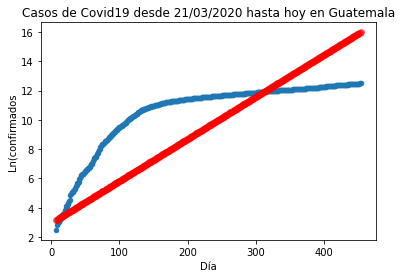

In [32]:
covidgt_lineal.plot.scatter(x = 'numDias',y='ln(confirmed)')
plt.scatter(x = covidgt_lineal['numDias'], y = hastaHoy, color = 'red', alpha = 0.5)
plt.title('Casos de Covid19 desde 21/03/2020 hasta hoy en Guatemala')
plt.xlabel("Día")
plt.ylabel('Ln(confirmados')
plt.show()

### Calcula el número de día hasta el fin de mes

In [33]:
#from datetime import timedelta
from datetime import datetime
from calendar import monthrange
 
def last_day_of_month(date_value):
    return date_value.replace(day = monthrange(date_value.year, date_value.month)[1])
 
given_date = datetime.today().date()
print("\nGiven date:", given_date, " --> Last day of month:", last_day_of_month(given_date),
       last_day_of_month(given_date)-given_date )
dias = (last_day_of_month(given_date)-given_date)
pdias = dias.days + len(covidgt["Date"])
pdias


Given date: 2021-06-11  --> Last day of month: 2021-06-30 19 days, 0:00:00


473

## Pronóstico de hoy (día de corrida) hasta el fin de mes

In [34]:
#pdias=473
predFinMes = w[0][0] * np.linspace(1,pdias, pdias) + w[0][1]
predFinMes

array([ 2.9893166 ,  3.0180097 ,  3.0467028 ,  3.0753959 ,  3.104089  ,
        3.13278211,  3.16147521,  3.19016831,  3.21886141,  3.24755451,
        3.27624761,  3.30494071,  3.33363381,  3.36232691,  3.39102001,
        3.41971311,  3.44840621,  3.47709931,  3.50579241,  3.53448551,
        3.56317861,  3.59187171,  3.62056481,  3.64925791,  3.67795101,
        3.70664411,  3.73533721,  3.76403031,  3.79272342,  3.82141652,
        3.85010962,  3.87880272,  3.90749582,  3.93618892,  3.96488202,
        3.99357512,  4.02226822,  4.05096132,  4.07965442,  4.10834752,
        4.13704062,  4.16573372,  4.19442682,  4.22311992,  4.25181302,
        4.28050612,  4.30919922,  4.33789232,  4.36658542,  4.39527852,
        4.42397163,  4.45266473,  4.48135783,  4.51005093,  4.53874403,
        4.56743713,  4.59613023,  4.62482333,  4.65351643,  4.68220953,
        4.71090263,  4.73959573,  4.76828883,  4.79698193,  4.82567503,
        4.85436813,  4.88306123,  4.91175433,  4.94044743,  4.96

In [39]:
valorPron = predFinMes[-1]

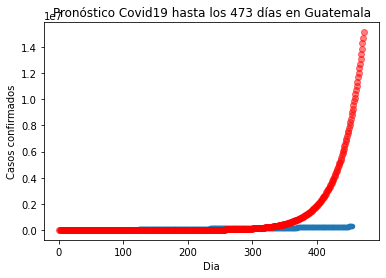

In [35]:
covidgt_lineal.plot.scatter(x = 'numDias', y = 'Confirmed')

plt.scatter(x = np.linspace(1,pdias, pdias), y = np.exp(predFinMes), color = 'red', alpha = 0.5)
plt.title('Pronóstico Covid19 hasta los ' + str(pdias) + ' días en Guatemala')
plt.xlabel("Dia")
plt.ylabel('Casos confirmados')
plt.show()

In [45]:
np.exp(valorPron)

15134084.500056123